In [31]:
import math
import os
import warnings
from glob import glob
from itertools import cycle
import re

import matplotlib.pyplot as plt
plt.style.use("grayscale")

import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')

In [32]:
def rounddown(x):
     return int(math.ceil(x / 100.0)) * 100 - 100

def removed_outliers(df, column, level=3):
    return df[((df[column] - df[column].mean()) / df[column].std()).abs() < level]

In [33]:
def smoothen_plot(x, y, smooth_power=300):
    smoothened_x = np.linspace(x.min(), x.max(), smooth_power)
    spl = make_interp_spline(x, y, k=3)
    smoothened_y = spl(smoothened_x)
    return smoothened_x, smoothened_y

In [34]:
def create_plot_ac_u_comp(df, cumulative=False, plot_title="", clean=3, smooth_u=0, smooth_ac=0, draw_v_lines=False):
    if clean:
        cleaned_df = removed_outliers(df, 'ac_iter_time', level=clean)
        cleaned_df = removed_outliers(cleaned_df, 'norm_iter_time', level=clean)
        cleaned_df.reset_index(drop=True, inplace=True)
    else:
        cleaned_df = df

    fig, ax = plt.subplots(figsize=(15, 5))
    if plot_title:
        ax.set_title(plot_title)

    ax.set_xlabel('Iteration')
    if cumulative:
        ax.set_ylabel('Elapsed time [s]')
        cleaned_df.ac_iter_time = cleaned_df.ac_iter_time / (10 ** 9)
        cleaned_df.norm_iter_time = cleaned_df.norm_iter_time / (10 ** 9)
    else:
        ax.set_ylabel('Time of 10 iterations [ms]')
        cleaned_df.ac_iter_time = cleaned_df.ac_iter_time / (10 ** 6)
        cleaned_df.norm_iter_time = cleaned_df.norm_iter_time / (10 ** 6)

    if smooth_ac:
        new_iter_no, ac_iter_time_smooth = smoothen_plot(cleaned_df.iteration_no, cleaned_df.ac_iter_time, smooth_ac)
    else:
        new_iter_no, ac_iter_time_smooth = cleaned_df.iteration_no, cleaned_df.ac_iter_time

    ax.plot(new_iter_no, ac_iter_time_smooth, label='Active cells', c='black', ls='-.')

    if smooth_u:
        new_iter_no, norm_iter_time_smooth = smoothen_plot(cleaned_df.iteration_no, cleaned_df.norm_iter_time, smooth_u)
    else:
        new_iter_no, norm_iter_time_smooth = cleaned_df.iteration_no, cleaned_df.norm_iter_time

    ax.plot(new_iter_no, norm_iter_time_smooth, label='Non-active cells', c='black', ls=':')

    iteration_no = cleaned_df['iteration_no']

    cross_point = ((cleaned_df['ac_iter_time'] - cleaned_df['norm_iter_time']).abs()).idxmin()
    if draw_v_lines:
        ax.axvline(x=iteration_no[cross_point], lw=1, ls='--', c='black')
        y_lim = ax.get_ylim()
        x_lim = ax.get_xlim()
        ax.text(iteration_no[cross_point] - x_lim[1] * .01,
                (y_lim[1] - y_lim[0]) * .02 + y_lim[0],
                'Iteration time crossover', rotation=90)

    xs = (
      list(range(0, cleaned_df.shape[0], round(cleaned_df.shape[0] / 6)))
      + [cross_point, len(cleaned_df) - 1]
    )
    xticks = [iteration_no[i]  for i in xs]


    ax.set_xticks([rounddown(i) for i in xticks])

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel('Fraction of active cells in CA')

    secax.set_xticks(xticks)
    secax.set_xticklabels([
        f'{cleaned_df[cleaned_df.iteration_no == i].ac_coverage.iloc[0] * 100:.0f}%'
        for i in xticks
    ])

    plt.legend()
    return fig


In [35]:
def read_ca_size_data(dir_path = "results/paper/ca_size/", test_name="standard"):
    df = pd.DataFrame()
    df["ca_size"] = range(1000,9000,1000)

    files = sorted(glob(f"{dir_path}/{test_name}/*{1000}*"))
    for j,file in enumerate(files):
        params_match = re.search(r"\d", file)
        file_name = os.path.basename(file[:params_match.start()])
        file_name = file_name.replace("coverage_","")
        file_data=[]
        for i, ca_size in enumerate(df.ca_size):
            files = glob(f"{dir_path}/{test_name}/*{file_name}*{ca_size}*")
            file_df = pd.read_csv(files[0], skiprows=2, names=["ac_coverage",'iter_time', 'z', 'x', 'y'])
            file_data.append(file_df["iter_time"].cumsum().iloc[-1] / 10**9)
        df[file_name]=file_data

    return df

In [36]:
def create_ca_size_plot(df, clean=3 ):
    fig, ax = plt.subplots(figsize=(10, 5))

    if clean != -1:
        for test in df:
            df = removed_outliers(df, test, level=clean)
            df.reset_index(drop=True, inplace=True)

    ca_size = df['ca_size']
    df.drop(['ca_size'], axis=1, inplace=True)

    ax.set_xlabel('CA dimension')
    ax.set_ylabel('Elapsed time [s]')

    line_styles = cycle([":", "--", "-.", "-"])
    marker_styles = cycle(("o", "x", "*", "+", "D", "X", ".", "s"))
    for file_name in df:
        ax.plot(ca_size,
                df[file_name],
                linestyle=next(line_styles),
                marker=next(marker_styles),
                label=file_name.replace("_", " ").title(),
                )

    plt.legend()
    return fig

In [37]:
if not os.path.isdir("charts"):
    os.makedirs("charts")

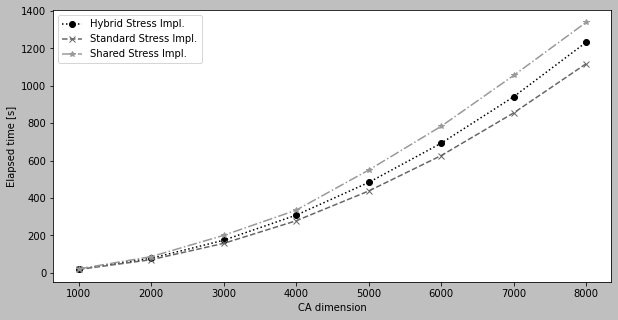

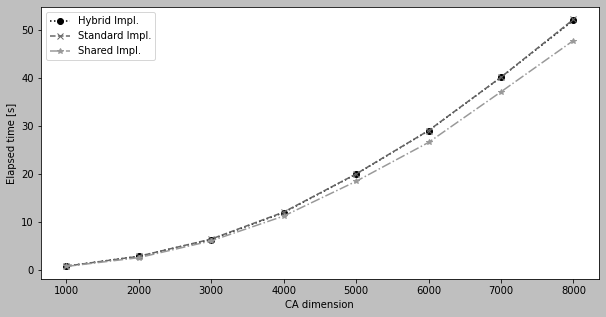

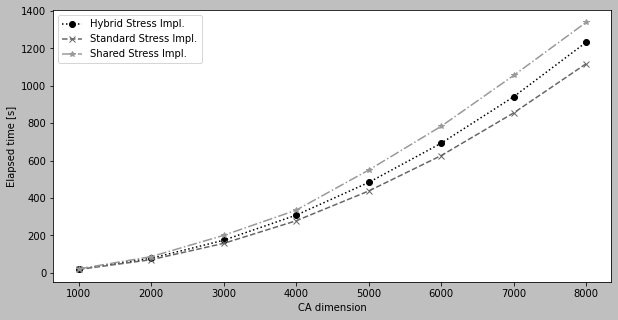

In [38]:
df=read_ca_size_data()
df = df.rename(columns={
     "u_hybrid_": "Hybrid impl.",
     "u_standard_": "Shared impl.",
     "u_shared_": "Standard impl.",
})
create_ca_size_plot(df)

df=read_ca_size_data(test_name="standard_stress")
df = df.rename(columns={
     "u_hybrid_stress_": "Hybrid stress impl.",
     "u_standard_stress_": "Shared stress impl.",
     "u_shared_stress_": "Standard stress impl.",
})
create_ca_size_plot(df)

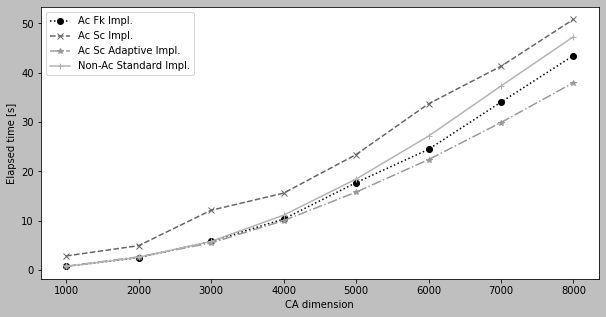

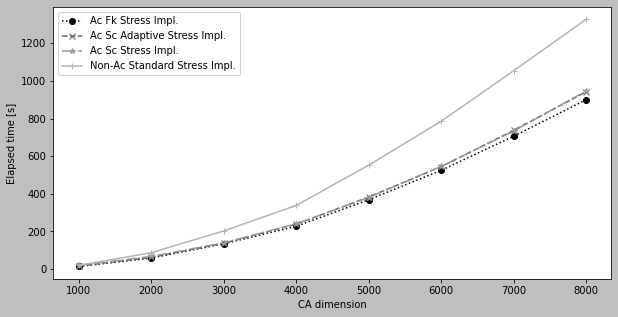

In [39]:
df=read_ca_size_data(test_name="active_cells")
df.drop("ac_u_sc_", axis=1, inplace=True)
df = df.rename(columns={
     "ac_u_naive_": "AC FK impl.",
     "ac_u_sc_one_kernel_adaptive_": "AC SC adaptive impl.",
     "ac_u_sc_fk_": "AC SC impl.",
     "u_standard_": "Non-AC standard impl.",
})

create_ca_size_plot(df)
plt.savefig("charts/active_cells_ca_size.pdf")

df=read_ca_size_data(test_name="active_cells_stress")
df.drop("ac_u_sc_stress_", axis=1, inplace=True)

df = df.rename(columns={
     "ac_u_naive_stress_": "AC FK stress impl.",
     "ac_u_sc_one_kernel_adaptive_stress_": "AC SC adaptive stress impl.",
     "ac_u_sc_one_kernel_stress_": "AC SC stress impl.",
     "u_standard_stress_": "Non-AC standard stress impl.",
})

create_ca_size_plot(df)
plt.savefig("charts/active_cells_ca_size_stress.pdf")
